# 01: EDA: Data Discovery (Exploration & Cleanup)

**Purpose:** Load master tables and run structured data discovery to understand missing data, types, duplicates, outliers, and consistency. Each step includes a description of the aim and interpretation of results. Targets (`target_backorder_risk`, `target_overstock_risk`) are built by `src/features/build_targets.py` and written to `*_with_targets.csv`.

**Inputs:** `../data/processed/`: core: master_order_fulfillment, master_inventory_material, master_purchase; BRD: master_order_fulfillment_brd, shipment_history, master_woc; ML: master_order_fulfillment_with_targets, master_inventory_material_with_targets

**Outputs:** DataFrames, SQLite db, discovery tables and figures in `../output/`

In [1]:
# Setup: imports (pandas, numpy, scipy, sklearn, matplotlib, seaborn, statsmodels)
# -----------------------------------------------------------------------------
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

_cwd = os.getcwd()
PROJECT_ROOT = os.path.dirname(_cwd) if os.path.basename(_cwd) == "notebooks" else _cwd
PROCESSED = os.path.join(PROJECT_ROOT, "data", "processed")
DB_PATH = os.path.join(PROJECT_ROOT, "data", "processed", "master_tables.db")
REPORTS_FIG = os.path.join(PROJECT_ROOT, "output", "figures")
REPORTS_TABLES = os.path.join(PROJECT_ROOT, "output", "tables")
os.makedirs(REPORTS_FIG, exist_ok=True)
os.makedirs(REPORTS_TABLES, exist_ok=True)

try:
    plt.style.use("seaborn-v0_8-whitegrid")
except OSError:
    plt.style.use("seaborn-whitegrid")
sns.set_theme(style="whitegrid", palette="husl", font_scale=1.1)
plt.rcParams["figure.facecolor"] = "white"

In [2]:
# Load master tables into DataFrames + SQLite (dbs for manipulation)
# -----------------------------------------------------------------------------
# Use order_brd as primary order table (has all base cols + BRD metrics)
order = pd.read_csv(os.path.join(PROCESSED, "master_order_fulfillment_brd.csv"), low_memory=False)
inventory = pd.read_csv(os.path.join(PROCESSED, "master_inventory_material.csv"), low_memory=False)
purchase = pd.read_csv(os.path.join(PROCESSED, "master_purchase.csv"), low_memory=False)
shipment_history = pd.read_csv(os.path.join(PROCESSED, "shipment_history.csv"), low_memory=False)
woc = pd.read_csv(os.path.join(PROCESSED, "master_woc.csv"), low_memory=False)

# Write to SQLite for SQL-style querying
conn = sqlite3.connect(DB_PATH)
order.to_sql("order_fulfillment", conn, if_exists="replace", index=False)
inventory.to_sql("inventory_material", conn, if_exists="replace", index=False)
purchase.to_sql("purchase", conn, if_exists="replace", index=False)
shipment_history.to_sql("shipment_history", conn, if_exists="replace", index=False)
woc.to_sql("master_woc", conn, if_exists="replace", index=False)
conn.close()
print("Loaded into DataFrames and SQLite:", DB_PATH)

print("master_order_fulfillment_brd:", order.shape)
print("master_inventory_material:", inventory.shape)
print("master_purchase:", purchase.shape)
print("shipment_history:", shipment_history.shape)
print("master_woc:", woc.shape)

Loaded into DataFrames and SQLite: /Users/addycruz/Desktop/data_capstone/data/processed/master_tables.db
master_order_fulfillment_brd: (52118, 41)
master_inventory_material: (66219, 15)
master_purchase: (861753, 14)
shipment_history: (11926, 5)
master_woc: (25569, 9)


In [3]:
# BRD metrics summary (from master_order_fulfillment_brd)
# -----------------------------------------------------------------------------
if "is_open" in order.columns:
    pct_open = order["is_open"].mean() * 100
    print(f"Open orders (outstanding_qty > 0): {pct_open:.1f}%")
if "backorder_units" in order.columns:
    n_backorder = (order["backorder_units"] > 0).sum()
    print(f"Rows with backorder_units > 0: {n_backorder:,} ({n_backorder/len(order)*100:.1f}%)")

Open orders (outstanding_qty > 0): 32.9%
Rows with backorder_units > 0: 5,381 (10.3%)


In [4]:
# SQLite query example (db manipulation)
# -----------------------------------------------------------------------------
conn = sqlite3.connect(DB_PATH)
sample = pd.read_sql_query("SELECT * FROM order_fulfillment LIMIT 5", conn)
conn.close()
print("Sample via SQL:")
display(sample)

Sample via SQL:


,client_id,sales_document_number,item_number,material_number,material_description,material_description_text,material_type,product_hierarchy,item_category,customer_number,...,billing_status,goods_movement_status,effective_shipment_date,outstanding_qty,is_open,saleable_inventory,backorder_units,backorder_amount,backorder_aging_days,backorder_aging_bucket
0,800,0000015353,10,000000000000002733,Notebook Basic 15,Notebook Basic 15,HALB,001700010000000110,TAK,Z42302,...,None,None,2013-06-06,32.0,1,0.0,32.0,0.0,4627.0,31+
1,800,0000015146,10,000000000000002733,Notebook Basic 15,Notebook Basic 15,HALB,001700010000000110,TAK,Z42302,...,None,None,2013-04-19,137.0,1,0.0,137.0,56444.0,4675.0,31+
2,800,0000015136,10,000000000000002733,Notebook Basic 15,Notebook Basic 15,HALB,001700010000000110,TAK,CU01,...,None,None,2013-04-18,140.0,1,0.0,140.0,64820.0,4676.0,31+
3,800,0000015133,10,000000000000002733,Notebook Basic 15,Notebook Basic 15,HALB,001700010000000110,TAK,CU05,...,None,None,2013-04-18,138.0,1,0.0,138.0,45954.0,4676.0,31+
4,800,0000015141,10,000000000000002733,Notebook Basic 15,Notebook Basic 15,HALB,001700010000000110,TAK,Z42302,...,None,None,2013-04-19,180.0,1,0.0,180.0,107460.0,4675.0,31+


---
## Data Discovery

The following sections systematically explore the master tables to identify data quality issues that may need cleaning before modeling. Each step states what we're looking for, runs the analysis, and interprets the results.

### 1. Missing Data

**Aim:** Identify which columns have missing values and how severe the problem is. Missing data can bias models or cause failures; we need to know where it occurs before deciding whether to impute, drop, or handle it another way.

In [5]:
# Missing data: count and % per column for all three tables
# -----------------------------------------------------------------------------
def missing_summary(df, name):
    m = df.isnull().sum()
    m = m[m > 0].sort_values(ascending=False)
    out = pd.DataFrame({"count": m, "pct": (m / len(df) * 100).round(1)})
    return out

missing_order = missing_summary(order, "order")
missing_inv = missing_summary(inventory, "inventory")
missing_purch = missing_summary(purchase, "purchase")

print("Order fulfillment: columns with missing values:")
display(missing_order.head(15))
print("\nInventory: columns with missing values:")
display(missing_inv.head(10))
print("\nPurchase: columns with missing values:")
display(missing_purch.head(10))

# Save for cleanup phase
missing_order.to_csv(os.path.join(REPORTS_TABLES, "discovery_missing_order.csv"))
missing_inv.to_csv(os.path.join(REPORTS_TABLES, "discovery_missing_inventory.csv"))
missing_purch.to_csv(os.path.join(REPORTS_TABLES, "discovery_missing_purchase.csv"))

Order fulfillment: columns with missing values:


,count,pct
goods_movement_status,52113,100.0
requested_delivery_date_schedule,52097,100.0
total_confirmed_quantity,52097,100.0
total_requested_quantity,52097,100.0
billing_status,51627,99.1
storage_location,45798,87.9
backorder_aging_bucket,34986,67.1
backorder_aging_days,34986,67.1
total_billed_value,21384,41.0
total_billed_quantity,21384,41.0



Inventory: columns with missing values:


,count,pct
returns,66219,100.0
restricted_use_stock,66216,100.0
blocked_stock,66206,100.0
stock_in_quality_inspection,66175,99.9
material_description_text,31694,47.9
plant_name,28101,42.4
country_code,28101,42.4
unrestricted_stock,21477,32.4
material_group,819,1.2



Purchase: columns with missing values:


,count,pct
net_price,42,0.0
net_value,42,0.0


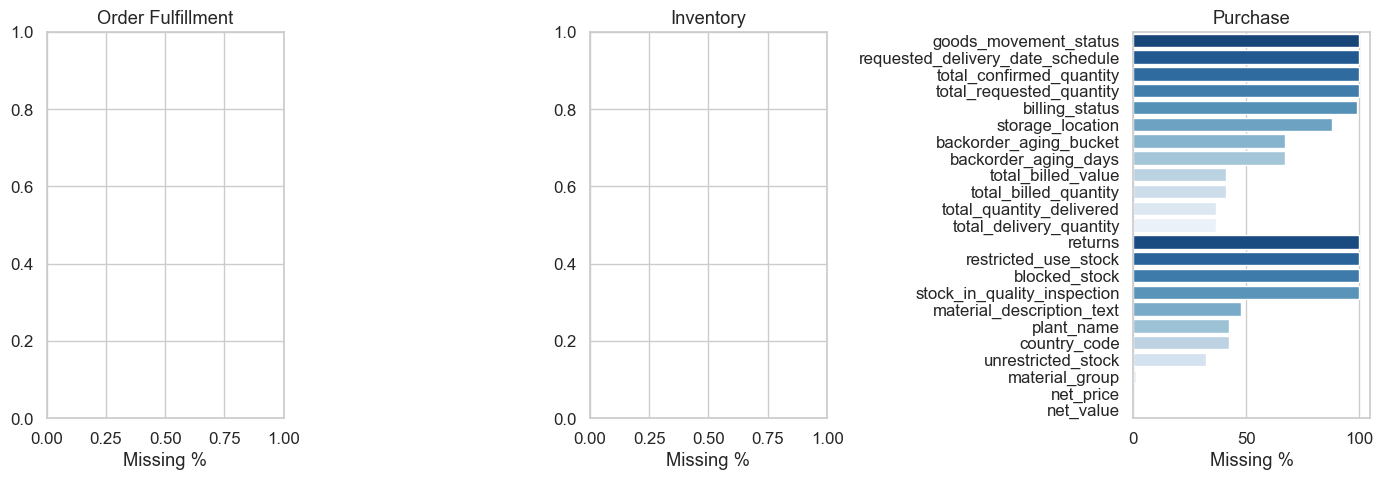

In [6]:
# Missing data visualization
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
for ax, (m_df, title) in zip(axes, [
    (missing_order.head(12), "Order Fulfillment"),
    (missing_inv.head(10), "Inventory"),
    (missing_purch.head(10), "Purchase"),
]):
    if len(m_df) > 0:
        sns.barplot(data=m_df.reset_index(), x="pct", y="index", hue="index", palette="Blues_r", legend=False)
        ax.set_xlabel("Missing %")
        ax.set_ylabel("")
        ax.set_title(title)
    else:
        ax.text(0.5, 0.5, "No missing values", ha="center", va="center", transform=ax.transAxes)
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_FIG, "discovery_missing_values.png"), dpi=150, bbox_inches="tight")
plt.show()

**Results (interpretation):** Columns with high missing % may need imputation or exclusion for modeling. Critical IDs (such as `material_number`, `plant_code`) should have no or minimal missing values. Delivery/billing quantities with many missings may indicate orders not yet fulfilled. Save these tables for the cleanup phase.

### 2. Data Types & Value Ranges

**Aim:** Check that columns have the expected types (numeric, categorical, date) and that values fall within valid ranges. Mis-typed columns (such as numbers stored as text) or impossible values (negative quantities, future dates) need correction before modeling.

In [7]:
# Data types and sample ranges
# -----------------------------------------------------------------------------
print("Order fulfillment: dtypes and sample stats:")
print(order.dtypes)
print("\nNumeric columns (order):")
num_order = order.select_dtypes(include=[np.number]).columns.tolist()
if num_order:
    display(order[num_order].describe())

Order fulfillment: dtypes and sample stats:
client_id                             int64
sales_document_number                object
item_number                           int64
material_number                      object
material_description                 object
material_description_text            object
material_type                        object
product_hierarchy                    object
item_category                        object
customer_number                      object
customer_name                        object
country_code                         object
order_date                           object
requested_delivery_date              object
requested_delivery_date_schedule     object
cumulative_order_quantity           float64
cumulative_confirmed_quantity       float64
total_requested_quantity            float64
total_confirmed_quantity            float64
total_delivery_quantity             float64
total_quantity_delivered            float64
total_billed_quantity           

,client_id,item_number,cumulative_order_quantity,cumulative_confirmed_quantity,total_requested_quantity,total_confirmed_quantity,total_delivery_quantity,total_quantity_delivered,total_billed_quantity,total_billed_value,net_value,order_header_net_value,outstanding_qty,saleable_inventory,backorder_units,backorder_amount,backorder_aging_days
count,52118.000000,52118.000000,4.866600e+04,4.769500e+04,21.000000,21.000000,3.295700e+04,3.295700e+04,30734.000000,3.073400e+04,4.668900e+04,4.723600e+04,5.211800e+04,5.211800e+04,5.211800e+04,5.211800e+04,17132.000000
mean,509.573468,3564.901819,1.911133e+02,1.952823e+02,1504.285714,846.761905,1.284827e+03,1.635017e+03,91.475618,1.210584e+05,3.931248e+05,4.280308e+05,1.474851e+02,6.255870e+05,1.323511e+02,2.970456e+05,3134.683458
std,341.698252,49693.589866,1.123647e+04,1.134079e+04,1623.175811,1080.143967,1.031154e+05,1.031298e+05,1173.581881,9.668280e+06,1.526597e+07,1.519112e+07,1.084257e+04,1.007671e+07,1.083122e+04,1.333552e+07,1761.611603
min,50.000000,1.000000,-2.000000e+00,-2.000000e+00,22.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.998120e+06,-1.000000e+06,-9.993000e+05,0.000000e+00,0.000000e+00,0.000000e+00,-2.268000e+04,1382.000000
25%,100.000000,10.000000,4.000000e+00,4.000000e+00,96.000000,22.000000,4.000000e+00,4.000000e+00,4.000000,9.120000e+02,4.880000e+02,9.000000e+02,0.000000e+00,5.340000e+02,0.000000e+00,0.000000e+00,1733.000000
50%,800.000000,10.000000,1.000000e+01,1.000000e+01,1224.000000,100.000000,1.000000e+01,1.000000e+01,14.000000,5.510000e+03,3.000710e+03,6.530000e+03,0.000000e+00,4.361000e+03,0.000000e+00,0.000000e+00,3250.000000
75%,800.000000,20.000000,4.500000e+01,8.000000e+01,2544.000000,1600.000000,5.900000e+01,5.400000e+01,50.000000,5.887090e+04,1.773800e+04,7.944700e+04,4.000000e+00,5.001000e+04,0.000000e+00,0.000000e+00,3829.000000
max,800.000000,700012.000000,2.000000e+06,2.000000e+06,6000.000000,3000.000000,1.234568e+07,1.234568e+07,200000.000000,1.669200e+09,1.298000e+09,1.298000e+09,2.000000e+06,1.000003e+09,2.000000e+06,1.298000e+09,13183.000000


In [ ]:

# -----------------------------------------------------------------------------
order["cumulative_order_quantity"] = pd.to_numeric(order["cumulative_order_quantity"], errors="coerce")
order["total_delivery_quantity"] = pd.to_numeric(order["total_delivery_quantity"], errors="coerce")
order["order_date"] = pd.to_datetime(order["order_date"], errors="coerce")

neg_qty_order = (order["cumulative_order_quantity"] < 0).sum()
neg_delivery = (order["total_delivery_quantity"] < 0).sum()
future_dates = (order["order_date"] > pd.Timestamp.today()).sum()
print(f"Order: negative order qty: {neg_qty_order}, negative delivery qty: {neg_delivery}, future order dates: {future_dates}")

inventory["unrestricted_stock"] = pd.to_numeric(inventory["unrestricted_stock"], errors="coerce")
neg_stock = (inventory["unrestricted_stock"] < 0).sum()
print(f"Inventory: negative stock: {neg_stock}")

Order: negative order qty: 1, negative delivery qty: 0, future order dates: 0
Inventory: negative stock: 5


**Results (interpretation):** Any non-zero counts for negative quantities or future dates indicate data errors to fix. Mixed dtypes (such as object where numeric expected) may need conversion. Use `pd.to_numeric(..., errors="coerce")` for numeric columns.

### 3. Duplicates

**Aim:** Verify that key identifiers are unique where expected. For order fulfillment, each row should represent one unique sales order item (`client_id` + `sales_document_number` + `item_number`). Duplicates can inflate counts and bias models.

In [9]:
# Duplicate check: key identifiers
# -----------------------------------------------------------------------------
order_key = ["client_id", "sales_document_number", "item_number"]
inv_key = ["client_id", "material_number", "plant_code", "storage_location"]
purch_key = ["client_id", "purchase_order_number", "purchase_order_item_number"]

dup_order = order.duplicated(subset=order_key).sum()
dup_inv = inventory.duplicated(subset=inv_key).sum()
dup_purch = purchase.duplicated(subset=purch_key).sum()

print(f"Order: {dup_order:,} duplicate rows (expected unique: client + sales_doc + item)")
print(f"Inventory: {dup_inv:,} duplicate rows (expected unique: client + material + plant + storage)")
print(f"Purchase: {dup_purch:,} duplicate rows (expected unique: client + PO + PO item)")

Order: 0 duplicate rows (expected unique: client + sales_doc + item)
Inventory: 36,200 duplicate rows (expected unique: client + material + plant + storage)
Purchase: 817,425 duplicate rows (expected unique: client + PO + PO item)


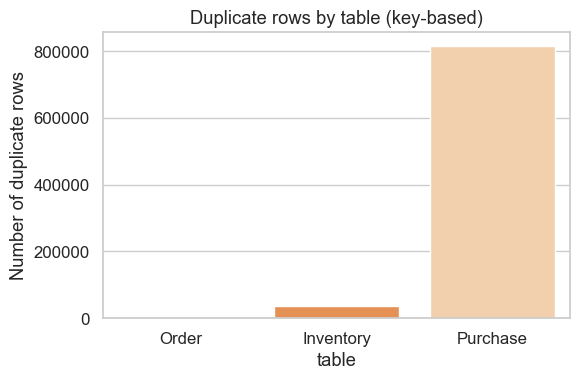

In [10]:
# Duplicate visualization
# -----------------------------------------------------------------------------
dup_data = pd.DataFrame({
    "table": ["Order", "Inventory", "Purchase"],
    "duplicates": [dup_order, dup_inv, dup_purch],
})
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=dup_data, x="table", y="duplicates", hue="table", palette="Oranges_r", legend=False)
ax.set_ylabel("Number of duplicate rows")
ax.set_title("Duplicate rows by table (key-based)")
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_FIG, "discovery_duplicates.png"), dpi=150, bbox_inches="tight")
plt.show()

**Results (interpretation):** Non-zero duplicate counts mean we should `drop_duplicates()` before modeling. Inventory and purchase may legitimately have multiple rows per material/plant (such as different storage locations); adjust the key if needed.

### 4. Outliers

**Aim:** Detect extreme values in numeric columns that could skew models or indicate data errors. We use percentiles and box plots to see where the bulk of data lies and whether very large values dominate.

In [11]:
# Outlier analysis: percentiles and box plots
# -----------------------------------------------------------------------------
qty_cols = ["cumulative_order_quantity", "total_delivery_quantity", "net_value"]
qty_cols = [c for c in qty_cols if c in order.columns]
order_numeric = order[qty_cols].apply(pd.to_numeric, errors="coerce")

percentiles = order_numeric.quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
print("Order fulfillment: percentiles for key numeric columns:")
display(percentiles)

Order fulfillment: percentiles for key numeric columns:


,cumulative_order_quantity,total_delivery_quantity,net_value
0.01,1.0,0.00,2.460
0.05,1.0,1.00,13.838
0.25,4.0,4.00,488.000
0.50,10.0,10.00,3000.710
0.75,45.0,59.00,17738.000
0.95,219.0,603.20,100000.000
0.99,700.0,4314.44,469264.000


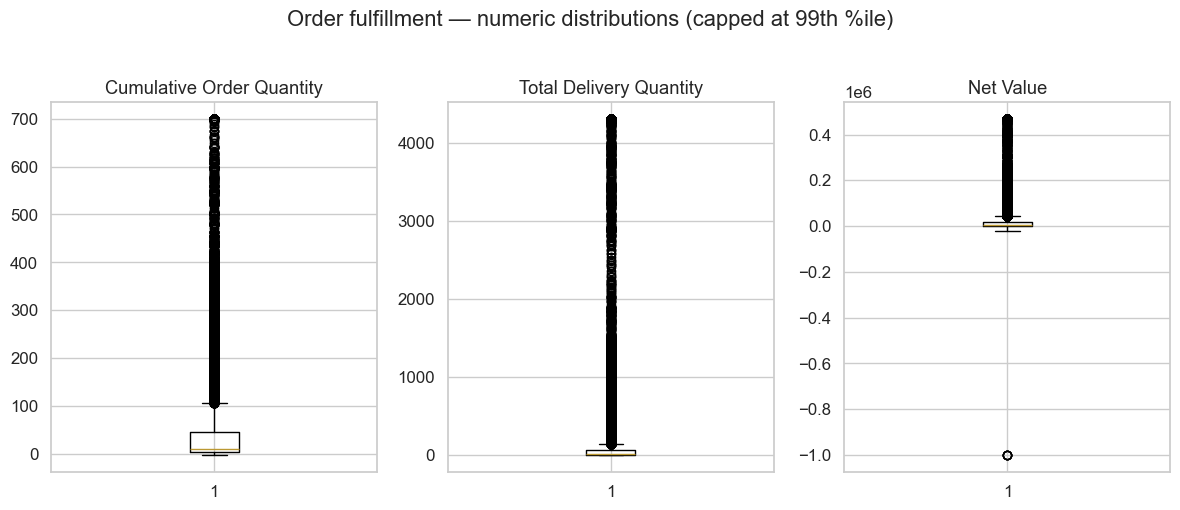

In [12]:
# Outlier visualization: box plots (clipped to 99th percentile for readability)
# -----------------------------------------------------------------------------
plot_df = order_numeric.copy()
for c in plot_df.columns:
    p99 = plot_df[c].quantile(0.99)
    plot_df[c] = plot_df[c].clip(upper=p99)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
for i, col in enumerate(plot_df.columns):
    data = plot_df[col].dropna()
    if len(data) > 0:
        axes[i].boxplot(data, vert=True)
    axes[i].set_ylabel("")
    axes[i].set_title(col.replace("_", " ").title())
plt.suptitle("Order fulfillment: numeric distributions (capped at 99th %ile)", y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_FIG, "discovery_outliers_boxplot.png"), dpi=150, bbox_inches="tight")
plt.show()

**Results (interpretation):** Large gaps between 95th and 99th percentiles indicate heavy tails; consider winsorizing or clipping for modeling. Zero or near-zero medians with high max values suggest many small transactions and few large ones; common in order data.

### 5. Cross-Table Consistency

**Aim:** Check that IDs that appear in multiple tables (such as `material_number`, `plant_code`) align. Materials in orders should exist in inventory; mismatches may indicate join issues or data from different time periods.

In [13]:
# Cross-table: materials in order vs inventory
# -----------------------------------------------------------------------------
order_mats = set(order["material_number"].dropna().astype(str).unique())
inv_mats = set(inventory["material_number"].dropna().astype(str).unique())
in_both = order_mats & inv_mats
order_only = order_mats - inv_mats

print(f"Materials in order: {len(order_mats):,}")
print(f"Materials in inventory: {len(inv_mats):,}")
print(f"Materials in both: {len(in_both):,}")
print(f"Materials in order but NOT inventory: {len(order_only):,}")

Materials in order: 3,238
Materials in inventory: 16,305
Materials in both: 2,195
Materials in order but NOT inventory: 1,043


**Results (interpretation):** Materials in order but not in inventory may be discontinued, from different plants, or a timing/join issue. Large `order_only` counts warrant investigation before modeling.

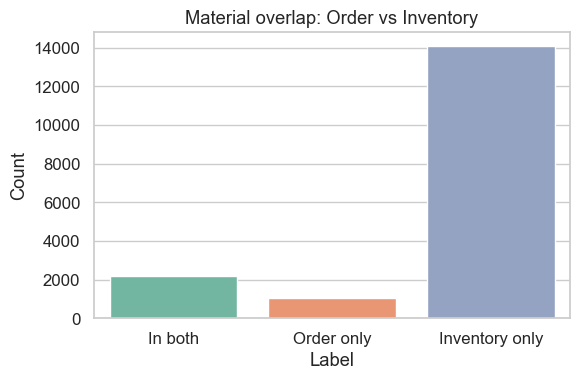

In [14]:
# Cross-table consistency visualization
# -----------------------------------------------------------------------------
venn_data = pd.DataFrame({
    "Overlap": [len(in_both), len(order_only), len(inv_mats - order_mats)],
    "Label": ["In both", "Order only", "Inventory only"],
})
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=venn_data, x="Label", y="Overlap", hue="Label", palette="Set2", legend=False)
ax.set_ylabel("Count")
ax.set_title("Material overlap: Order vs Inventory")
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_FIG, "discovery_cross_table_consistency.png"), dpi=150, bbox_inches="tight")
plt.show()

---
## Discovery Summary

Discovery outputs saved:
- `output/figures/discovery_*.png`: visualizations
- `output/tables/`: missing value tables (from step 1)

**Targets:** Backorder and overstock targets are built by `python -m src.features.build_targets` (or `run_pipeline.py`). Outputs: `master_order_fulfillment_with_targets.csv` (target_backorder_risk), `master_inventory_material_with_targets.csv` (target_overstock_risk). Use these in 02_modeling.